In [1]:
trial_number_ml = "004"
random_state_init = 444

In [2]:
# %%
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# optuna
import optuna
import optuna.integration.lightgbm as lgb_optuna
from optuna.pruners import MedianPruner
from optuna.integration import OptunaSearchCV

#xgboost
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance


# metrics
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score, make_scorer, precision_recall_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold

#lightgbm
import lightgbm as lgb
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns


from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole # Enables RDKit's IPython integration for Jupyter notebooks.
from IPython.display import display


import os
from rdkit.Chem.Draw import rdMolDraw2D

import joblib


# %%
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
import os

# Get the current working directory
current_dir = os.getcwd()
print("Current Directory:", current_dir)

# Verify the change
new_dir = os.getcwd()
print("New Working Directory:", new_dir)


Current Directory: /home/ubuntu/diplomka/notebooks_ipynb/ml/model3_binder_nonbinder
New Working Directory: /home/ubuntu/diplomka/notebooks_ipynb/ml/model3_binder_nonbinder


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

def load_and_concatenate_datasets(file_paths):
    """
    Load datasets from given file paths and concatenate them into a single DataFrame.
    """
    dataframes = [pd.read_pickle(path) for path in file_paths]
    return pd.concat(dataframes, ignore_index=True)

def preprocess_data(df, feature_col='ecfp6', label_col='label'):
    """
    Preprocess the DataFrame by extracting features and labels.
    """
    X = np.array([list(map(int, list(fp))) for fp in df[feature_col]])
    y = df[label_col].values
    return X, y

def stratified_train_test_split(X, y, test_size=0.2, random_state=42):
    """
    Split the dataset into training and test sets, ensuring stratification of the target variable.
    """
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

# Paths for the datasets
model3_files = ['../../data_for_ml/ml_datasets_set2/model3_binders_nonbinders/data.pkl']

# Load datasets
model3_df = load_and_concatenate_datasets(model3_files)

# Preprocess datasets
X3, y3 = preprocess_data(model3_df)

# Split datasets
X_train, X_test, y_train, y_test = stratified_train_test_split(X3, y3)

# Output shapes
print(f"Model 3 - Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")


Model 3 - Training set size: 3137, Test set size: 785


In [5]:
import numpy as np
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from optuna.integration import OptunaSearchCV


def model_training_and_evaluation(model, X_train, y_train, X_test, y_test):
    """
    Train and evaluate a model using given datasets.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return model, accuracy

def objective(trial, model_cls, X_train, y_train):
    """
    Objective function for hyperparameter tuning with Optuna.
    
    Args:
    - trial (optuna.trial.Trial): An individual trial object.
    - model_cls: The classifier class to be optimized.
    - X_train, y_train: Training data.
    
    Returns:
    - The accuracy of the model on the cross-validation folds.
    """
    # Suggest hyperparameters specific to the RandomForestClassifier
    if model_cls == RandomForestClassifier:
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        max_depth = trial.suggest_int('max_depth', 10, 100)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
        
        model = model_cls(n_estimators=n_estimators, max_depth=max_depth,
                          min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                          max_features=max_features, random_state=random_state_init, n_jobs=4)
        
    elif model_cls == XGBClassifier:
        n_estimators = trial.suggest_int('n_estimators', 100, 1000, log=True)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
        min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
        subsample = trial.suggest_float('subsample', 0.5, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
        gamma = trial.suggest_float('gamma', 0, 5)
        reg_lambda = trial.suggest_float('reg_lambda', 0.01, 10.0, log=True)
        reg_alpha = trial.suggest_float('reg_alpha', 0.01, 10.0, log=True)

        model = model_cls(n_estimators=n_estimators, max_depth=max_depth,
                        learning_rate=learning_rate, min_child_weight=min_child_weight,
                        subsample=subsample, colsample_bytree=colsample_bytree,
                        gamma=gamma, reg_lambda=reg_lambda, reg_alpha=reg_alpha,
                        random_state=random_state_init, use_label_encoder=False, eval_metric='logloss', n_jobs=4)
    
    elif model_cls == LGBMClassifier:
        boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss'])
        num_leaves = trial.suggest_int('num_leaves', 31, 100)
        max_depth = trial.suggest_int('max_depth', -1, 15)
        learning_rate = trial.suggest_float('learning_rate', 0.001, 0.5)
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        min_child_weight = trial.suggest_float('min_child_weight', 1e-3, 1e-1, log=True)
        min_child_samples = trial.suggest_int('min_child_samples', 20, 2000)
        subsample = trial.suggest_float('subsample', 0.8, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.8, 1.0)
        reg_alpha = trial.suggest_float('reg_alpha', 1e-10, 1.0, log=True)
        reg_lambda = trial.suggest_float('reg_lambda', 1e-10, 1.0, log=True)
        
        model = model_cls(boosting_type=boosting_type, num_leaves=num_leaves, max_depth=max_depth,
                        learning_rate=learning_rate, n_estimators=n_estimators,
                        min_child_weight=min_child_weight, min_child_samples=min_child_samples,
                        subsample=subsample, colsample_bytree=colsample_bytree,
                        reg_alpha=reg_alpha, reg_lambda=reg_lambda, random_state=random_state_init, verbosity=-1, n_jobs=4)
    else:
        raise NotImplementedError("Optuna objective function needs to be extended for other classifiers.")
    
    # Cross-validation within the Optuna trial
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state_init)
    accuracies = []
    for train_index, val_index in stratified_kfold.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
        
        model.fit(X_fold_train, y_fold_train)
        y_fold_pred = model.predict(X_fold_val)
        accuracy = accuracy_score(y_fold_val, y_fold_pred)
        accuracies.append(accuracy)
        
        trial.report(np.mean(accuracies), len(accuracies))
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    return np.mean(accuracies)

def perform_hyperparameter_tuning(model_cls, X_train, y_train, n_trials=50):
    """
    Perform hyperparameter tuning for the given model class using Optuna.
    """
    study = optuna.create_study(direction='maximize')
    objective_with_model = lambda trial: objective(trial, model_cls, X_train, y_train)
    study.optimize(objective_with_model, n_trials=n_trials, n_jobs=4) 
    
    print(f"Best trial for {model_cls.__name__}:")
    print(f"  Value: {study.best_trial.value}")
    print("  Params: ")
    for key, value in study.best_trial.params.items():
        print(f"    {key}: {value}")
    print('')
    return study.best_params

print('')
# Example usage for RandomForestClassifier
best_params_rf = perform_hyperparameter_tuning(RandomForestClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for RandomForestClassifier:", best_params_rf)
# Train and evaluate the final model with the best hyperparameters
best_rf = RandomForestClassifier(**best_params_rf, random_state=random_state_init)
final_model, final_accuracy = model_training_and_evaluation(best_rf, X_train, y_train, X_test, y_test)
print(f"RandomForestClassifier accuracy: {final_accuracy:.4f}")
print('')

# Example usage for XGBClassifier
best_params_xgb = perform_hyperparameter_tuning(XGBClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for XGBClassifier:", best_params_xgb)
# Train and evaluate the final model with the best hyperparameters
best_xgb = XGBClassifier(**best_params_xgb, random_state=random_state_init, use_label_encoder=False, eval_metric='logloss')
final_model, final_accuracy = model_training_and_evaluation(best_xgb, X_train, y_train, X_test, y_test)
print(f"XGBClassifier accuracy: {final_accuracy:.4f}")
print('')

# Example usage for LGBMClassifier
best_params_lgb = perform_hyperparameter_tuning(LGBMClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for LGBMClassifier:", best_params_lgb)
# Train and evaluate the final model with the best hyperparameters
best_lgb = LGBMClassifier(**best_params_lgb, random_state=random_state_init, verbosity=-1)
final_model, final_accuracy = model_training_and_evaluation(best_lgb, X_train, y_train, X_test, y_test)
print(f"LGBMClassifier accuracy: {final_accuracy:.4f}")

print(f"LGBMClassifier accuracy: {final_accuracy:.4f}")
print('')


[I 2024-05-01 15:40:33,139] A new study created in memory with name: no-name-58fd72f1-fc05-49d9-9909-6c818412a6cc


[I 2024-05-01 15:41:03,388] Trial 0 finished with value: 0.7277715133229716 and parameters: {'n_estimators': 151, 'max_depth': 96, 'min_samples_split': 20, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7277715133229716.


[I 2024-05-01 15:41:35,470] Trial 3 finished with value: 0.7402000223488658 and parameters: {'n_estimators': 273, 'max_depth': 55, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.7402000223488658.


[I 2024-05-01 15:41:46,763] Trial 1 finished with value: 0.7252227267647985 and parameters: {'n_estimators': 440, 'max_depth': 22, 'min_samples_split': 16, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.7402000223488658.


[I 2024-05-01 15:42:17,174] Trial 2 finished with value: 0.7213980231412347 and parameters: {'n_estimators': 912, 'max_depth': 23, 'min_samples_split': 10, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 3 with value: 0.7402000223488658.


[I 2024-05-01 15:42:45,432] Trial 6 finished with value: 0.7312807931815641 and parameters: {'n_estimators': 532, 'max_depth': 83, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 3 with value: 0.7402000223488658.


[I 2024-05-01 15:42:46,285] Trial 4 pruned. 


[I 2024-05-01 15:42:49,226] Trial 8 pruned. 


[I 2024-05-01 15:43:05,936] Trial 5 finished with value: 0.7300053840449415 and parameters: {'n_estimators': 835, 'max_depth': 66, 'min_samples_split': 13, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 3 with value: 0.7402000223488658.


[I 2024-05-01 15:43:07,635] Trial 9 pruned. 


[I 2024-05-01 15:43:13,522] Trial 12 pruned. 


[I 2024-05-01 15:43:23,600] Trial 11 finished with value: 0.7236257987179877 and parameters: {'n_estimators': 127, 'max_depth': 22, 'min_samples_split': 8, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.7402000223488658.


[I 2024-05-01 15:44:01,117] Trial 7 pruned. 


[I 2024-05-01 15:44:13,908] Trial 13 finished with value: 0.7379676754132001 and parameters: {'n_estimators': 371, 'max_depth': 43, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.7402000223488658.


[I 2024-05-01 15:44:15,965] Trial 15 pruned. 


[I 2024-05-01 15:44:58,456] Trial 14 finished with value: 0.7389286766423877 and parameters: {'n_estimators': 581, 'max_depth': 43, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 3 with value: 0.7402000223488658.


[I 2024-05-01 15:45:19,869] Trial 10 finished with value: 0.7370198803319823 and parameters: {'n_estimators': 866, 'max_depth': 47, 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.7402000223488658.


[I 2024-05-01 15:45:24,433] Trial 18 pruned. 


[I 2024-05-01 15:45:43,853] Trial 17 finished with value: 0.7453016588953565 and parameters: {'n_estimators': 346, 'max_depth': 38, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 17 with value: 0.7453016588953565.


[I 2024-05-01 15:45:46,287] Trial 16 finished with value: 0.735740407765215 and parameters: {'n_estimators': 356, 'max_depth': 41, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 17 with value: 0.7453016588953565.


[I 2024-05-01 15:45:47,226] Trial 20 pruned. 


[I 2024-05-01 15:45:54,883] Trial 21 pruned. 


[I 2024-05-01 15:45:58,661] Trial 22 pruned. 


[I 2024-05-01 15:45:59,589] Trial 23 pruned. 


[I 2024-05-01 15:46:17,481] Trial 26 pruned. 


[I 2024-05-01 15:46:36,548] Trial 27 pruned. 


[I 2024-05-01 15:47:07,988] Trial 28 pruned. 


[I 2024-05-01 15:47:21,105] Trial 19 pruned. 


[I 2024-05-01 15:47:52,980] Trial 29 pruned. 


[I 2024-05-01 15:47:54,344] Trial 25 finished with value: 0.7408415363829377 and parameters: {'n_estimators': 456, 'max_depth': 32, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 17 with value: 0.7453016588953565.


[I 2024-05-01 15:47:56,531] Trial 24 finished with value: 0.7433938784424873 and parameters: {'n_estimators': 469, 'max_depth': 54, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 17 with value: 0.7453016588953565.


[I 2024-05-01 15:49:03,317] Trial 30 finished with value: 0.7405225571165899 and parameters: {'n_estimators': 369, 'max_depth': 57, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 17 with value: 0.7453016588953565.


[I 2024-05-01 15:49:23,680] Trial 31 finished with value: 0.7417989821107488 and parameters: {'n_estimators': 351, 'max_depth': 34, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 17 with value: 0.7453016588953565.


[I 2024-05-01 15:49:24,458] Trial 32 finished with value: 0.7392456241936631 and parameters: {'n_estimators': 351, 'max_depth': 33, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 17 with value: 0.7453016588953565.


[I 2024-05-01 15:49:29,605] Trial 33 finished with value: 0.7382886863946201 and parameters: {'n_estimators': 363, 'max_depth': 32, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 17 with value: 0.7453016588953565.


[I 2024-05-01 15:49:44,464] Trial 35 pruned. 


[I 2024-05-01 15:49:49,044] Trial 36 pruned. 


[I 2024-05-01 15:49:58,403] Trial 39 pruned. 


[I 2024-05-01 15:50:06,339] Trial 38 pruned. 


[I 2024-05-01 15:50:18,802] Trial 40 pruned. 


[I 2024-05-01 15:50:34,756] Trial 41 pruned. 


[I 2024-05-01 15:50:36,182] Trial 34 finished with value: 0.7405205254015177 and parameters: {'n_estimators': 372, 'max_depth': 33, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 17 with value: 0.7453016588953565.


[I 2024-05-01 15:50:45,717] Trial 42 pruned. 


[I 2024-05-01 15:50:51,383] Trial 43 pruned. 


[I 2024-05-01 15:51:22,422] Trial 37 finished with value: 0.739566127246315 and parameters: {'n_estimators': 478, 'max_depth': 26, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 17 with value: 0.7453016588953565.


[I 2024-05-01 15:52:00,151] Trial 44 finished with value: 0.7427538881947195 and parameters: {'n_estimators': 306, 'max_depth': 62, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 17 with value: 0.7453016588953565.


[I 2024-05-01 15:52:14,431] Trial 45 finished with value: 0.7392456241936631 and parameters: {'n_estimators': 327, 'max_depth': 58, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 17 with value: 0.7453016588953565.


[I 2024-05-01 15:52:19,432] Trial 46 finished with value: 0.7430703278172268 and parameters: {'n_estimators': 321, 'max_depth': 75, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 17 with value: 0.7453016588953565.


[I 2024-05-01 15:52:29,157] Trial 49 pruned. 


[I 2024-05-01 15:52:35,784] Trial 47 finished with value: 0.7402010382064019 and parameters: {'n_estimators': 324, 'max_depth': 61, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 17 with value: 0.7453016588953565.


[I 2024-05-01 15:52:37,118] Trial 48 pruned. 


Best trial for RandomForestClassifier:
  Value: 0.7453016588953565
  Params: 
    n_estimators: 346
    max_depth: 38
    min_samples_split: 5
    min_samples_leaf: 1
    max_features: sqrt

Best hyperparameters for RandomForestClassifier: {'n_estimators': 346, 'max_depth': 38, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}


[I 2024-05-01 15:52:45,739] A new study created in memory with name: no-name-b95cb2dc-24c0-430b-b532-bc12d6fc1f27


RandomForestClassifier accuracy: 0.7427



[I 2024-05-01 15:53:00,951] Trial 2 finished with value: 0.7016309592742713 and parameters: {'n_estimators': 137, 'max_depth': 10, 'learning_rate': 0.20109343354922, 'min_child_weight': 10, 'subsample': 0.5984290839257966, 'colsample_bytree': 0.8905089927127272, 'gamma': 1.984720333802445, 'reg_lambda': 0.03630047331904706, 'reg_alpha': 0.1772009556982184}. Best is trial 2 with value: 0.7016309592742713.


[I 2024-05-01 15:53:05,855] Trial 0 finished with value: 0.7159692804681071 and parameters: {'n_estimators': 433, 'max_depth': 3, 'learning_rate': 0.16152525673067716, 'min_child_weight': 8, 'subsample': 0.5491869565967059, 'colsample_bytree': 0.6162327297522505, 'gamma': 4.70044088520999, 'reg_lambda': 0.08786697763195685, 'reg_alpha': 0.4641652108509391}. Best is trial 0 with value: 0.7159692804681071.


[I 2024-05-01 15:53:10,677] Trial 3 finished with value: 0.7000269202247077 and parameters: {'n_estimators': 430, 'max_depth': 6, 'learning_rate': 0.15376587398228928, 'min_child_weight': 8, 'subsample': 0.6274513640527735, 'colsample_bytree': 0.695300222082414, 'gamma': 2.468449216575306, 'reg_lambda': 0.050438355418930624, 'reg_alpha': 0.03747272838692426}. Best is trial 0 with value: 0.7159692804681071.


[I 2024-05-01 15:53:25,212] Trial 5 finished with value: 0.7188416176515405 and parameters: {'n_estimators': 223, 'max_depth': 7, 'learning_rate': 0.09521285401714502, 'min_child_weight': 1, 'subsample': 0.6765853459161573, 'colsample_bytree': 0.671182243934866, 'gamma': 0.711517203946947, 'reg_lambda': 0.038799587670261794, 'reg_alpha': 0.44000095775549003}. Best is trial 5 with value: 0.7188416176515405.


[I 2024-05-01 15:53:25,709] Trial 1 finished with value: 0.7373337803106491 and parameters: {'n_estimators': 625, 'max_depth': 6, 'learning_rate': 0.014779872252038865, 'min_child_weight': 4, 'subsample': 0.6664243325190082, 'colsample_bytree': 0.9335491077604434, 'gamma': 1.7463087270031774, 'reg_lambda': 0.7614602534074958, 'reg_alpha': 0.06966241407200328}. Best is trial 1 with value: 0.7373337803106491.


[I 2024-05-01 15:53:28,695] Trial 7 pruned. 


[I 2024-05-01 15:53:38,709] Trial 6 pruned. 


[I 2024-05-01 15:53:40,019] Trial 8 finished with value: 0.7255371346722337 and parameters: {'n_estimators': 223, 'max_depth': 4, 'learning_rate': 0.027484416556031024, 'min_child_weight': 3, 'subsample': 0.8992361111731009, 'colsample_bytree': 0.7019650877483204, 'gamma': 2.6269461541432264, 'reg_lambda': 0.09510064781119866, 'reg_alpha': 1.6048339472116357}. Best is trial 1 with value: 0.7373337803106491.


[I 2024-05-01 15:53:50,208] Trial 4 finished with value: 0.7178826481374252 and parameters: {'n_estimators': 818, 'max_depth': 9, 'learning_rate': 0.04742690793166641, 'min_child_weight': 7, 'subsample': 0.9702518368977879, 'colsample_bytree': 0.998911456852875, 'gamma': 0.762928079522483, 'reg_lambda': 3.975086985479495, 'reg_alpha': 0.025957100906539528}. Best is trial 1 with value: 0.7373337803106491.


[I 2024-05-01 15:53:51,054] Trial 11 pruned. 


[I 2024-05-01 15:54:01,730] Trial 12 finished with value: 0.7245776572293502 and parameters: {'n_estimators': 186, 'max_depth': 10, 'learning_rate': 0.15645583351074346, 'min_child_weight': 1, 'subsample': 0.7876841528303276, 'colsample_bytree': 0.9418840413073812, 'gamma': 2.862253054164101, 'reg_lambda': 0.17788774971791887, 'reg_alpha': 0.016597823148849597}. Best is trial 1 with value: 0.7373337803106491.


[I 2024-05-01 15:54:03,423] Trial 9 finished with value: 0.7287218480480299 and parameters: {'n_estimators': 555, 'max_depth': 6, 'learning_rate': 0.02820159148131579, 'min_child_weight': 3, 'subsample': 0.5975342282694404, 'colsample_bytree': 0.6868756880001848, 'gamma': 1.9039903727707441, 'reg_lambda': 8.187618175149161, 'reg_alpha': 1.3412951928827999}. Best is trial 1 with value: 0.7373337803106491.


[I 2024-05-01 15:54:06,507] Trial 14 pruned. 


[I 2024-05-01 15:54:11,026] Trial 15 pruned. 


[I 2024-05-01 15:54:11,125] Trial 10 finished with value: 0.7277689736791313 and parameters: {'n_estimators': 463, 'max_depth': 7, 'learning_rate': 0.029969130045870644, 'min_child_weight': 8, 'subsample': 0.5120546808133362, 'colsample_bytree': 0.7415907606533063, 'gamma': 3.3548444140831117, 'reg_lambda': 0.7047039676650191, 'reg_alpha': 0.8796815933507826}. Best is trial 1 with value: 0.7373337803106491.


[I 2024-05-01 15:54:14,857] Trial 13 finished with value: 0.7271330468615081 and parameters: {'n_estimators': 545, 'max_depth': 5, 'learning_rate': 0.07162825952589996, 'min_child_weight': 4, 'subsample': 0.8285324988073912, 'colsample_bytree': 0.8113514997862841, 'gamma': 3.8423053146112225, 'reg_lambda': 0.5988738121892813, 'reg_alpha': 0.010687276126924827}. Best is trial 1 with value: 0.7373337803106491.


[I 2024-05-01 15:54:19,285] Trial 19 pruned. 


[I 2024-05-01 15:54:20,087] Trial 18 pruned. 


[I 2024-05-01 15:54:20,671] Trial 17 pruned. 


[I 2024-05-01 15:54:24,671] Trial 20 pruned. 


[I 2024-05-01 15:54:24,950] Trial 21 pruned. 


[I 2024-05-01 15:54:37,090] Trial 16 pruned. 


[I 2024-05-01 15:54:38,547] Trial 23 pruned. 


[I 2024-05-01 15:54:39,151] Trial 22 pruned. 


[I 2024-05-01 15:54:43,177] Trial 25 pruned. 


[I 2024-05-01 15:55:01,210] Trial 26 finished with value: 0.7264920407562043 and parameters: {'n_estimators': 412, 'max_depth': 8, 'learning_rate': 0.047934898436627196, 'min_child_weight': 7, 'subsample': 0.5583056380005729, 'colsample_bytree': 0.7378296507837675, 'gamma': 4.43643789411578, 'reg_lambda': 0.6846973547864363, 'reg_alpha': 0.9176311035261154}. Best is trial 1 with value: 0.7373337803106491.


[I 2024-05-01 15:55:04,799] Trial 24 finished with value: 0.725853574294741 and parameters: {'n_estimators': 989, 'max_depth': 8, 'learning_rate': 0.044534438565805246, 'min_child_weight': 6, 'subsample': 0.5493573591462357, 'colsample_bytree': 0.7531476750264268, 'gamma': 4.169231730064866, 'reg_lambda': 0.7310998619403741, 'reg_alpha': 0.9210251594336409}. Best is trial 1 with value: 0.7373337803106491.


[I 2024-05-01 15:55:08,711] Trial 28 finished with value: 0.7252151078332774 and parameters: {'n_estimators': 471, 'max_depth': 7, 'learning_rate': 0.036883162870035895, 'min_child_weight': 2, 'subsample': 0.5040532759049644, 'colsample_bytree': 0.7564747878282981, 'gamma': 3.084608814555642, 'reg_lambda': 0.30721984747393, 'reg_alpha': 1.0716008520012816}. Best is trial 1 with value: 0.7373337803106491.


[I 2024-05-01 15:55:12,435] Trial 27 finished with value: 0.7306362315748839 and parameters: {'n_estimators': 713, 'max_depth': 8, 'learning_rate': 0.04218366569837248, 'min_child_weight': 2, 'subsample': 0.5530915824254183, 'colsample_bytree': 0.7488220895362364, 'gamma': 4.329573655753157, 'reg_lambda': 0.7787431617734301, 'reg_alpha': 0.9878737122721716}. Best is trial 1 with value: 0.7373337803106491.


[I 2024-05-01 15:55:24,592] Trial 32 pruned. 


[I 2024-05-01 15:55:30,533] Trial 29 finished with value: 0.7296787858470728 and parameters: {'n_estimators': 468, 'max_depth': 6, 'learning_rate': 0.03102893444365111, 'min_child_weight': 2, 'subsample': 0.5006287075149611, 'colsample_bytree': 0.7903676786789706, 'gamma': 3.2423176892876557, 'reg_lambda': 0.28049045980066567, 'reg_alpha': 1.0101668568044346}. Best is trial 1 with value: 0.7373337803106491.


[I 2024-05-01 15:55:36,185] Trial 31 finished with value: 0.73669683763549 and parameters: {'n_estimators': 367, 'max_depth': 6, 'learning_rate': 0.02062268332068055, 'min_child_weight': 2, 'subsample': 0.6303781547139454, 'colsample_bytree': 0.651218193326354, 'gamma': 1.9724050808858133, 'reg_lambda': 1.4337193428146144, 'reg_alpha': 0.150125625519738}. Best is trial 1 with value: 0.7373337803106491.


[I 2024-05-01 15:55:36,791] Trial 30 finished with value: 0.725854590152277 and parameters: {'n_estimators': 498, 'max_depth': 6, 'learning_rate': 0.02844627830702801, 'min_child_weight': 2, 'subsample': 0.5027868652386236, 'colsample_bytree': 0.7772026369182619, 'gamma': 3.0820384715765163, 'reg_lambda': 0.40717766869043415, 'reg_alpha': 0.16832353612079579}. Best is trial 1 with value: 0.7373337803106491.


[I 2024-05-01 15:55:59,668] Trial 33 finished with value: 0.7379707229858086 and parameters: {'n_estimators': 369, 'max_depth': 9, 'learning_rate': 0.01101871788175208, 'min_child_weight': 3, 'subsample': 0.6923983617275006, 'colsample_bytree': 0.6466957176298069, 'gamma': 2.058215254699917, 'reg_lambda': 1.3935733298843378, 'reg_alpha': 0.32995220021800226}. Best is trial 33 with value: 0.7379707229858086.


[I 2024-05-01 15:56:02,071] Trial 34 finished with value: 0.7335070449720131 and parameters: {'n_estimators': 390, 'max_depth': 6, 'learning_rate': 0.018220986128720976, 'min_child_weight': 2, 'subsample': 0.5714767275071888, 'colsample_bytree': 0.654812683903882, 'gamma': 2.171445589046074, 'reg_lambda': 1.4185193284750663, 'reg_alpha': 0.3745561036379163}. Best is trial 33 with value: 0.7379707229858086.


[I 2024-05-01 15:56:03,038] Trial 37 pruned. 


[I 2024-05-01 15:56:03,202] Trial 36 finished with value: 0.736697345564258 and parameters: {'n_estimators': 371, 'max_depth': 6, 'learning_rate': 0.013534176303319486, 'min_child_weight': 1, 'subsample': 0.6251464231940987, 'colsample_bytree': 0.8877242568617416, 'gamma': 2.4695276141686384, 'reg_lambda': 1.3586119233862428, 'reg_alpha': 0.2886275769191639}. Best is trial 33 with value: 0.7379707229858086.


[I 2024-05-01 15:56:04,131] Trial 38 pruned. 


[I 2024-05-01 15:56:08,028] Trial 41 pruned. 


[I 2024-05-01 15:56:08,345] Trial 39 pruned. 


[I 2024-05-01 15:56:09,324] Trial 35 finished with value: 0.7395620638161703 and parameters: {'n_estimators': 375, 'max_depth': 9, 'learning_rate': 0.013869365766773601, 'min_child_weight': 1, 'subsample': 0.6917698458209014, 'colsample_bytree': 0.6366645316820176, 'gamma': 3.777806583171993, 'reg_lambda': 1.223018552283121, 'reg_alpha': 0.23662949891931276}. Best is trial 35 with value: 0.7395620638161703.


[I 2024-05-01 15:56:10,787] Trial 43 pruned. 


[I 2024-05-01 15:56:12,530] Trial 42 pruned. 


[I 2024-05-01 15:56:13,084] Trial 44 pruned. 


[I 2024-05-01 15:56:15,608] Trial 45 pruned. 


[I 2024-05-01 15:56:15,611] Trial 46 pruned. 


[I 2024-05-01 15:56:16,136] Trial 47 pruned. 


[I 2024-05-01 15:56:18,152] Trial 40 finished with value: 0.730315728522232 and parameters: {'n_estimators': 254, 'max_depth': 4, 'learning_rate': 0.057625818871843065, 'min_child_weight': 1, 'subsample': 0.6333591129696322, 'colsample_bytree': 0.9761860380459825, 'gamma': 1.7758287479340873, 'reg_lambda': 4.8092150084096215, 'reg_alpha': 0.029927949523659056}. Best is trial 35 with value: 0.7395620638161703.


[I 2024-05-01 15:56:18,254] Trial 48 pruned. 


[I 2024-05-01 15:56:24,659] Trial 49 finished with value: 0.7319111327827386 and parameters: {'n_estimators': 414, 'max_depth': 7, 'learning_rate': 0.054937254735163546, 'min_child_weight': 3, 'subsample': 0.8079195853220076, 'colsample_bytree': 0.6768791673872675, 'gamma': 3.812830909066257, 'reg_lambda': 1.0145734033716822, 'reg_alpha': 0.23046831013471267}. Best is trial 35 with value: 0.7395620638161703.


Best trial for XGBClassifier:
  Value: 0.7395620638161703
  Params: 
    n_estimators: 375
    max_depth: 9
    learning_rate: 0.013869365766773601
    min_child_weight: 1
    subsample: 0.6917698458209014
    colsample_bytree: 0.6366645316820176
    gamma: 3.777806583171993
    reg_lambda: 1.223018552283121
    reg_alpha: 0.23662949891931276

Best hyperparameters for XGBClassifier: {'n_estimators': 375, 'max_depth': 9, 'learning_rate': 0.013869365766773601, 'min_child_weight': 1, 'subsample': 0.6917698458209014, 'colsample_bytree': 0.6366645316820176, 'gamma': 3.777806583171993, 'reg_lambda': 1.223018552283121, 'reg_alpha': 0.23662949891931276}


[I 2024-05-01 15:58:50,234] A new study created in memory with name: no-name-5105bb9e-c26f-44a7-97bf-9b91190320fb


XGBClassifier accuracy: 0.7223



[I 2024-05-01 15:58:50,895] Trial 1 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'goss', 'num_leaves': 54, 'max_depth': 7, 'learning_rate': 0.4871391953378767, 'n_estimators': 111, 'min_child_weight': 0.029121467295282276, 'min_child_samples': 1938, 'subsample': 0.9541512040609059, 'colsample_bytree': 0.8002601119928715, 'reg_alpha': 0.00019826446567634275, 'reg_lambda': 5.451635942363651e-06}. Best is trial 1 with value: 0.4995215311004785.


[I 2024-05-01 15:58:50,956] Trial 2 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'dart', 'num_leaves': 36, 'max_depth': 12, 'learning_rate': 0.4939500620772437, 'n_estimators': 130, 'min_child_weight': 0.026792337500748224, 'min_child_samples': 1545, 'subsample': 0.8940672233588716, 'colsample_bytree': 0.8461145336282256, 'reg_alpha': 1.1347301781186963e-07, 'reg_lambda': 1.2561179787329786e-06}. Best is trial 1 with value: 0.4995215311004785.


[I 2024-05-01 15:58:51,334] Trial 0 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 45, 'max_depth': 2, 'learning_rate': 0.2788289524836599, 'n_estimators': 692, 'min_child_weight': 0.005758604709424326, 'min_child_samples': 1899, 'subsample': 0.938581017543102, 'colsample_bytree': 0.8256890668318787, 'reg_alpha': 0.0493665994040143, 'reg_lambda': 0.00012767260471633352}. Best is trial 1 with value: 0.4995215311004785.


[I 2024-05-01 15:58:51,802] Trial 5 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'dart', 'num_leaves': 31, 'max_depth': 7, 'learning_rate': 0.11160623793982263, 'n_estimators': 529, 'min_child_weight': 0.04991542804495666, 'min_child_samples': 1642, 'subsample': 0.8732886350254255, 'colsample_bytree': 0.8279623204665224, 'reg_alpha': 2.0232756822084854e-10, 'reg_lambda': 8.823665641852837e-09}. Best is trial 1 with value: 0.4995215311004785.


[I 2024-05-01 15:58:52,054] Trial 6 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'dart', 'num_leaves': 45, 'max_depth': 5, 'learning_rate': 0.03595210599052712, 'n_estimators': 449, 'min_child_weight': 0.009057903973989978, 'min_child_samples': 1289, 'subsample': 0.8752809486295035, 'colsample_bytree': 0.9492468347730749, 'reg_alpha': 4.0704752719118954e-10, 'reg_lambda': 1.2611242770317058e-10}. Best is trial 1 with value: 0.4995215311004785.


[I 2024-05-01 15:58:53,803] Trial 3 finished with value: 0.6586058371174026 and parameters: {'boosting_type': 'goss', 'num_leaves': 82, 'max_depth': -1, 'learning_rate': 0.14437489227524322, 'n_estimators': 744, 'min_child_weight': 0.0590916581583625, 'min_child_samples': 566, 'subsample': 0.869493903702828, 'colsample_bytree': 0.8721545702537792, 'reg_alpha': 2.297539664175949e-08, 'reg_lambda': 0.00351683264219478}. Best is trial 3 with value: 0.6586058371174026.


[I 2024-05-01 15:58:54,200] Trial 8 finished with value: 0.6012169973282947 and parameters: {'boosting_type': 'goss', 'num_leaves': 44, 'max_depth': 1, 'learning_rate': 0.1547822371029773, 'n_estimators': 737, 'min_child_weight': 0.03606575935067773, 'min_child_samples': 943, 'subsample': 0.8368034585454223, 'colsample_bytree': 0.9262098945043903, 'reg_alpha': 1.4675104655847906e-05, 'reg_lambda': 1.530429961370576e-10}. Best is trial 3 with value: 0.6586058371174026.


[I 2024-05-01 15:58:54,823] Trial 10 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 56, 'max_depth': 9, 'learning_rate': 0.4432006461541586, 'n_estimators': 305, 'min_child_weight': 0.04738659340337263, 'min_child_samples': 1620, 'subsample': 0.9396237501856806, 'colsample_bytree': 0.9194325548438779, 'reg_alpha': 8.357942897868255e-06, 'reg_lambda': 0.0042693734986001385}. Best is trial 3 with value: 0.6586058371174026.


[I 2024-05-01 15:58:56,724] Trial 4 finished with value: 0.6764432795944697 and parameters: {'boosting_type': 'dart', 'num_leaves': 74, 'max_depth': 14, 'learning_rate': 0.43933206081609755, 'n_estimators': 276, 'min_child_weight': 0.001416844758688121, 'min_child_samples': 682, 'subsample': 0.9948423074494659, 'colsample_bytree': 0.942594870785425, 'reg_alpha': 0.0001041367819994921, 'reg_lambda': 0.004782019312066157}. Best is trial 4 with value: 0.6764432795944697.


[I 2024-05-01 15:58:57,437] Trial 12 finished with value: 0.513237639553429 and parameters: {'boosting_type': 'dart', 'num_leaves': 99, 'max_depth': 11, 'learning_rate': 0.01695346031370588, 'n_estimators': 115, 'min_child_weight': 0.001021688840213402, 'min_child_samples': 1251, 'subsample': 0.8290776200052611, 'colsample_bytree': 0.8826207994966668, 'reg_alpha': 2.9807839172204703e-09, 'reg_lambda': 0.7359818264904385}. Best is trial 4 with value: 0.6764432795944697.


[I 2024-05-01 15:58:59,098] Trial 9 finished with value: 0.6509472871524498 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 88, 'max_depth': 6, 'learning_rate': 0.2149706740613083, 'n_estimators': 943, 'min_child_weight': 0.022490435107746932, 'min_child_samples': 718, 'subsample': 0.9684402421435468, 'colsample_bytree': 0.8898973924885133, 'reg_alpha': 6.57230306336211e-07, 'reg_lambda': 1.6373175263572335e-09}. Best is trial 4 with value: 0.6764432795944697.


[I 2024-05-01 15:59:03,394] Trial 7 finished with value: 0.6917461575188696 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': 3, 'learning_rate': 0.49672622471931177, 'n_estimators': 613, 'min_child_weight': 0.0018354944416581968, 'min_child_samples': 29, 'subsample': 0.9186091784171853, 'colsample_bytree': 0.9116380673458108, 'reg_alpha': 1.0469422044664761e-07, 'reg_lambda': 0.04534419847197358}. Best is trial 7 with value: 0.6917461575188696.


[I 2024-05-01 15:59:05,226] Trial 11 finished with value: 0.5865546175804306 and parameters: {'boosting_type': 'dart', 'num_leaves': 54, 'max_depth': -1, 'learning_rate': 0.05414262275763044, 'n_estimators': 463, 'min_child_weight': 0.0539889049772382, 'min_child_samples': 1094, 'subsample': 0.9086008957727135, 'colsample_bytree': 0.9914735994573289, 'reg_alpha': 0.0001290666768364702, 'reg_lambda': 0.03366731954194805}. Best is trial 7 with value: 0.6917461575188696.


[I 2024-05-01 15:59:17,410] Trial 15 finished with value: 0.7003540263513445 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 69, 'max_depth': 15, 'learning_rate': 0.35118795018855536, 'n_estimators': 353, 'min_child_weight': 0.0012532030682923646, 'min_child_samples': 93, 'subsample': 0.9958556661491564, 'colsample_bytree': 0.9828023204842514, 'reg_alpha': 0.0036013980460983847, 'reg_lambda': 0.7226296450834446}. Best is trial 15 with value: 0.7003540263513445.


[I 2024-05-01 15:59:22,560] Trial 14 finished with value: 0.6621090218307785 and parameters: {'boosting_type': 'goss', 'num_leaves': 76, 'max_depth': 15, 'learning_rate': 0.32371854245360104, 'n_estimators': 763, 'min_child_weight': 0.0022631740311957944, 'min_child_samples': 63, 'subsample': 0.9936598839824242, 'colsample_bytree': 0.9940689294356545, 'reg_alpha': 0.002172292347081731, 'reg_lambda': 0.0206259488311938}. Best is trial 15 with value: 0.7003540263513445.


[I 2024-05-01 15:59:28,060] Trial 16 finished with value: 0.7048156726500676 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 71, 'max_depth': 15, 'learning_rate': 0.3706587584304102, 'n_estimators': 325, 'min_child_weight': 0.0011941782679403298, 'min_child_samples': 29, 'subsample': 0.9902630728502668, 'colsample_bytree': 0.9639347818354228, 'reg_alpha': 0.013367428269597654, 'reg_lambda': 0.3675164851454419}. Best is trial 16 with value: 0.7048156726500676.


[I 2024-05-01 15:59:30,207] Trial 18 finished with value: 0.6962128831052733 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 65, 'max_depth': 4, 'learning_rate': 0.3651234438314107, 'n_estimators': 339, 'min_child_weight': 0.0028006575181650454, 'min_child_samples': 24, 'subsample': 0.9163531043409847, 'colsample_bytree': 0.9676545827812332, 'reg_alpha': 0.8191409469892941, 'reg_lambda': 0.6682003839129532}. Best is trial 16 with value: 0.7048156726500676.


[I 2024-05-01 15:59:31,437] Trial 19 finished with value: 0.7041822854762848 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 66, 'max_depth': 13, 'learning_rate': 0.358862892895605, 'n_estimators': 289, 'min_child_weight': 0.003584394815847249, 'min_child_samples': 323, 'subsample': 0.9758640342544815, 'colsample_bytree': 0.9669724378963891, 'reg_alpha': 0.33541721810293806, 'reg_lambda': 0.5993072784891866}. Best is trial 16 with value: 0.7048156726500676.


[I 2024-05-01 15:59:32,698] Trial 20 finished with value: 0.6971708367618524 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 73, 'max_depth': 13, 'learning_rate': 0.36605164284934744, 'n_estimators': 234, 'min_child_weight': 0.004391707308030684, 'min_child_samples': 356, 'subsample': 0.9740809756690816, 'colsample_bytree': 0.9640237844155577, 'reg_alpha': 0.011288172384439188, 'reg_lambda': 5.975433479987139e-05}. Best is trial 16 with value: 0.7048156726500676.


[I 2024-05-01 15:59:33,446] Trial 21 finished with value: 0.6901568484035799 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 87, 'max_depth': 12, 'learning_rate': 0.4045745469971379, 'n_estimators': 218, 'min_child_weight': 0.0036107399757683667, 'min_child_samples': 427, 'subsample': 0.973532123476532, 'colsample_bytree': 0.9592615007952189, 'reg_alpha': 0.22951289058240626, 'reg_lambda': 0.0002466726441283453}. Best is trial 16 with value: 0.7048156726500676.


[I 2024-05-01 15:59:36,726] Trial 22 finished with value: 0.687923485610378 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 91, 'max_depth': 11, 'learning_rate': 0.25330902498398805, 'n_estimators': 420, 'min_child_weight': 0.0036653801324594117, 'min_child_samples': 363, 'subsample': 0.8064034146188807, 'colsample_bytree': 0.9435232157149491, 'reg_alpha': 0.8416499187488405, 'reg_lambda': 0.00030132730086776543}. Best is trial 16 with value: 0.7048156726500676.


[I 2024-05-01 15:59:38,514] Trial 23 finished with value: 0.6974857525980557 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 60, 'max_depth': 10, 'learning_rate': 0.2578110541849435, 'n_estimators': 423, 'min_child_weight': 0.011782186978289247, 'min_child_samples': 280, 'subsample': 0.8094753493044109, 'colsample_bytree': 0.9363966364592493, 'reg_alpha': 0.05934732175901749, 'reg_lambda': 1.460537389929184e-06}. Best is trial 16 with value: 0.7048156726500676.


[I 2024-05-01 15:59:41,166] Trial 17 finished with value: 0.7016243562002865 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 68, 'max_depth': 15, 'learning_rate': 0.3449660113953912, 'n_estimators': 380, 'min_child_weight': 0.0025541902598759047, 'min_child_samples': 21, 'subsample': 0.9968548954771779, 'colsample_bytree': 0.979249006292295, 'reg_alpha': 0.17211214333412503, 'reg_lambda': 0.27083114601344743}. Best is trial 16 with value: 0.7048156726500676.


[I 2024-05-01 15:59:42,164] Trial 24 finished with value: 0.6987637013785186 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 69, 'max_depth': 15, 'learning_rate': 0.3091320322035948, 'n_estimators': 369, 'min_child_weight': 0.0010463710179490016, 'min_child_samples': 256, 'subsample': 0.9963480682305037, 'colsample_bytree': 0.9848580989405048, 'reg_alpha': 0.004834133770348059, 'reg_lambda': 0.22340702593237688}. Best is trial 16 with value: 0.7048156726500676.


[I 2024-05-01 15:59:44,532] Trial 25 finished with value: 0.6914312416826665 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 69, 'max_depth': 15, 'learning_rate': 0.32653937225230145, 'n_estimators': 365, 'min_child_weight': 0.0011131352638890622, 'min_child_samples': 195, 'subsample': 0.9967515352040858, 'colsample_bytree': 0.9790227125025256, 'reg_alpha': 0.002761745094269257, 'reg_lambda': 0.16263945749936135}. Best is trial 16 with value: 0.7048156726500676.


[I 2024-05-01 15:59:44,888] Trial 26 finished with value: 0.7003519946362722 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 80, 'max_depth': 14, 'learning_rate': 0.31125082913132274, 'n_estimators': 216, 'min_child_weight': 0.0018926635742872462, 'min_child_samples': 195, 'subsample': 0.9578158550563123, 'colsample_bytree': 0.9797573105158015, 'reg_alpha': 0.033333147896797505, 'reg_lambda': 0.08947135245389125}. Best is trial 16 with value: 0.7048156726500676.


[I 2024-05-01 15:59:46,173] Trial 27 finished with value: 0.7019463830392426 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 80, 'max_depth': 13, 'learning_rate': 0.40366685923444323, 'n_estimators': 219, 'min_child_weight': 0.006913940314282084, 'min_child_samples': 194, 'subsample': 0.9594567786373716, 'colsample_bytree': 0.9731975549323607, 'reg_alpha': 0.04228896074645937, 'reg_lambda': 0.09312698096990388}. Best is trial 16 with value: 0.7048156726500676.


[I 2024-05-01 15:59:46,419] Trial 28 pruned. 


[I 2024-05-01 15:59:46,764] Trial 29 pruned. 


[I 2024-05-01 15:59:46,777] Trial 31 pruned. 


[I 2024-05-01 15:59:47,137] Trial 33 pruned. 


[I 2024-05-01 15:59:47,259] Trial 32 pruned. 


[I 2024-05-01 15:59:47,899] Trial 30 finished with value: 0.6911153099889271 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 80, 'max_depth': 9, 'learning_rate': 0.40234688793904105, 'n_estimators': 180, 'min_child_weight': 0.008214828571319662, 'min_child_samples': 511, 'subsample': 0.9358932767063073, 'colsample_bytree': 0.9613445732046548, 'reg_alpha': 0.0005741207267014279, 'reg_lambda': 0.0014391694641652478}. Best is trial 16 with value: 0.7048156726500676.


[I 2024-05-01 15:59:53,124] Trial 34 finished with value: 0.6974857525980557 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 77, 'max_depth': 14, 'learning_rate': 0.2826565139069275, 'n_estimators': 282, 'min_child_weight': 0.002509569548187491, 'min_child_samples': 166, 'subsample': 0.9423739167811206, 'colsample_bytree': 0.9538414084646204, 'reg_alpha': 0.12734568982922878, 'reg_lambda': 0.9580125241245024}. Best is trial 16 with value: 0.7048156726500676.


[I 2024-05-01 15:59:56,455] Trial 35 finished with value: 0.7032268714635459 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 76, 'max_depth': 14, 'learning_rate': 0.27913532609309677, 'n_estimators': 494, 'min_child_weight': 0.002756407584358171, 'min_child_samples': 170, 'subsample': 0.9476076228937368, 'colsample_bytree': 0.9549121390027889, 'reg_alpha': 0.12652480218251053, 'reg_lambda': 0.26472294883289293}. Best is trial 16 with value: 0.7048156726500676.


[I 2024-05-01 15:59:57,239] Trial 36 finished with value: 0.6958923800526214 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 74, 'max_depth': 14, 'learning_rate': 0.28594215751812735, 'n_estimators': 598, 'min_child_weight': 0.002502671666487685, 'min_child_samples': 185, 'subsample': 0.9488514176928013, 'colsample_bytree': 0.9521458131913999, 'reg_alpha': 0.1201137349306203, 'reg_lambda': 0.25148139577795436}. Best is trial 16 with value: 0.7048156726500676.


[I 2024-05-01 15:59:58,100] Trial 39 pruned. 


[I 2024-05-01 15:59:58,446] Trial 37 finished with value: 0.6958923800526214 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 71, 'max_depth': 12, 'learning_rate': 0.359330619708997, 'n_estimators': 498, 'min_child_weight': 0.09503188652616087, 'min_child_samples': 307, 'subsample': 0.9839026831119269, 'colsample_bytree': 0.9742393872054194, 'reg_alpha': 0.016401457266296805, 'reg_lambda': 0.2015116685608962}. Best is trial 16 with value: 0.7048156726500676.


[I 2024-05-01 15:59:58,650] Trial 41 pruned. 


[I 2024-05-01 15:59:58,927] Trial 42 pruned. 


[I 2024-05-01 16:00:00,021] Trial 43 pruned. 


[I 2024-05-01 16:00:01,817] Trial 44 pruned. 


[I 2024-05-01 16:00:03,046] Trial 40 finished with value: 0.6952579770213025 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 72, 'max_depth': 11, 'learning_rate': 0.21515203694094404, 'n_estimators': 602, 'min_child_weight': 0.0016711323976473927, 'min_child_samples': 422, 'subsample': 0.9825840361011132, 'colsample_bytree': 0.9715021119030941, 'reg_alpha': 0.7307524520242702, 'reg_lambda': 4.1915787536165975e-07}. Best is trial 16 with value: 0.7048156726500676.


[I 2024-05-01 16:00:03,418] Trial 38 pruned. 


[I 2024-05-01 16:00:04,293] Trial 46 pruned. 


[I 2024-05-01 16:00:04,475] Trial 48 pruned. 


[I 2024-05-01 16:00:04,834] Trial 47 pruned. 


[I 2024-05-01 16:00:17,746] Trial 49 finished with value: 0.6879199301090015 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 51, 'max_depth': 15, 'learning_rate': 0.37358122110368264, 'n_estimators': 257, 'min_child_weight': 0.002146413998012584, 'min_child_samples': 36, 'subsample': 0.9659762539659889, 'colsample_bytree': 0.9988277162325423, 'reg_alpha': 0.39267106197964885, 'reg_lambda': 0.3806523716351668}. Best is trial 16 with value: 0.7048156726500676.


[I 2024-05-01 16:00:22,274] Trial 13 finished with value: 0.7057746421641828 and parameters: {'boosting_type': 'dart', 'num_leaves': 76, 'max_depth': 15, 'learning_rate': 0.34024081774066733, 'n_estimators': 994, 'min_child_weight': 0.0010954684944008849, 'min_child_samples': 69, 'subsample': 0.9974946726870804, 'colsample_bytree': 0.9919438858647909, 'reg_alpha': 0.5876484109148364, 'reg_lambda': 0.7638807692181377}. Best is trial 13 with value: 0.7057746421641828.


[I 2024-05-01 16:00:23,183] Trial 45 finished with value: 0.6978021922205631 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 84, 'max_depth': 13, 'learning_rate': 0.33573889043538163, 'n_estimators': 387, 'min_child_weight': 0.0019543947932728657, 'min_child_samples': 27, 'subsample': 0.987256556548708, 'colsample_bytree': 0.9876919978197292, 'reg_alpha': 0.06202548035649297, 'reg_lambda': 0.30632128361114347}. Best is trial 13 with value: 0.7057746421641828.


Best trial for LGBMClassifier:
  Value: 0.7057746421641828
  Params: 
    boosting_type: dart
    num_leaves: 76
    max_depth: 15
    learning_rate: 0.34024081774066733
    n_estimators: 994
    min_child_weight: 0.0010954684944008849
    min_child_samples: 69
    subsample: 0.9974946726870804
    colsample_bytree: 0.9919438858647909
    reg_alpha: 0.5876484109148364
    reg_lambda: 0.7638807692181377

Best hyperparameters for LGBMClassifier: {'boosting_type': 'dart', 'num_leaves': 76, 'max_depth': 15, 'learning_rate': 0.34024081774066733, 'n_estimators': 994, 'min_child_weight': 0.0010954684944008849, 'min_child_samples': 69, 'subsample': 0.9974946726870804, 'colsample_bytree': 0.9919438858647909, 'reg_alpha': 0.5876484109148364, 'reg_lambda': 0.7638807692181377}


LGBMClassifier accuracy: 0.7159
LGBMClassifier accuracy: 0.7159



In [6]:
import os
import joblib

# Create necessary directories
output_dir = f'./output/sample_{trial_number_ml}'
results_dir = os.path.join(output_dir, 'results')
visual_dir = os.path.join(results_dir, 'visual')
models_dir = os.path.join(output_dir, 'models')
features_dir = os.path.join(output_dir, 'features')


os.makedirs(results_dir, exist_ok=True)
os.makedirs(visual_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)
os.makedirs(features_dir, exist_ok=True)


In [7]:
# save the best models as joblib
joblib.dump(best_rf, os.path.join(models_dir, 'best_rf.joblib'))
joblib.dump(best_xgb, os.path.join(models_dir, 'best_xgb.joblib'))
joblib.dump(best_lgb, os.path.join(models_dir, 'best_lgb.joblib'))

['./output/sample_004/models/best_lgb.joblib']

In [8]:
# load the models
best_rf = joblib.load(os.path.join(models_dir, 'best_rf.joblib'))
best_xgb = joblib.load(os.path.join(models_dir, 'best_xgb.joblib'))
best_lgb = joblib.load(os.path.join(models_dir, 'best_lgb.joblib'))

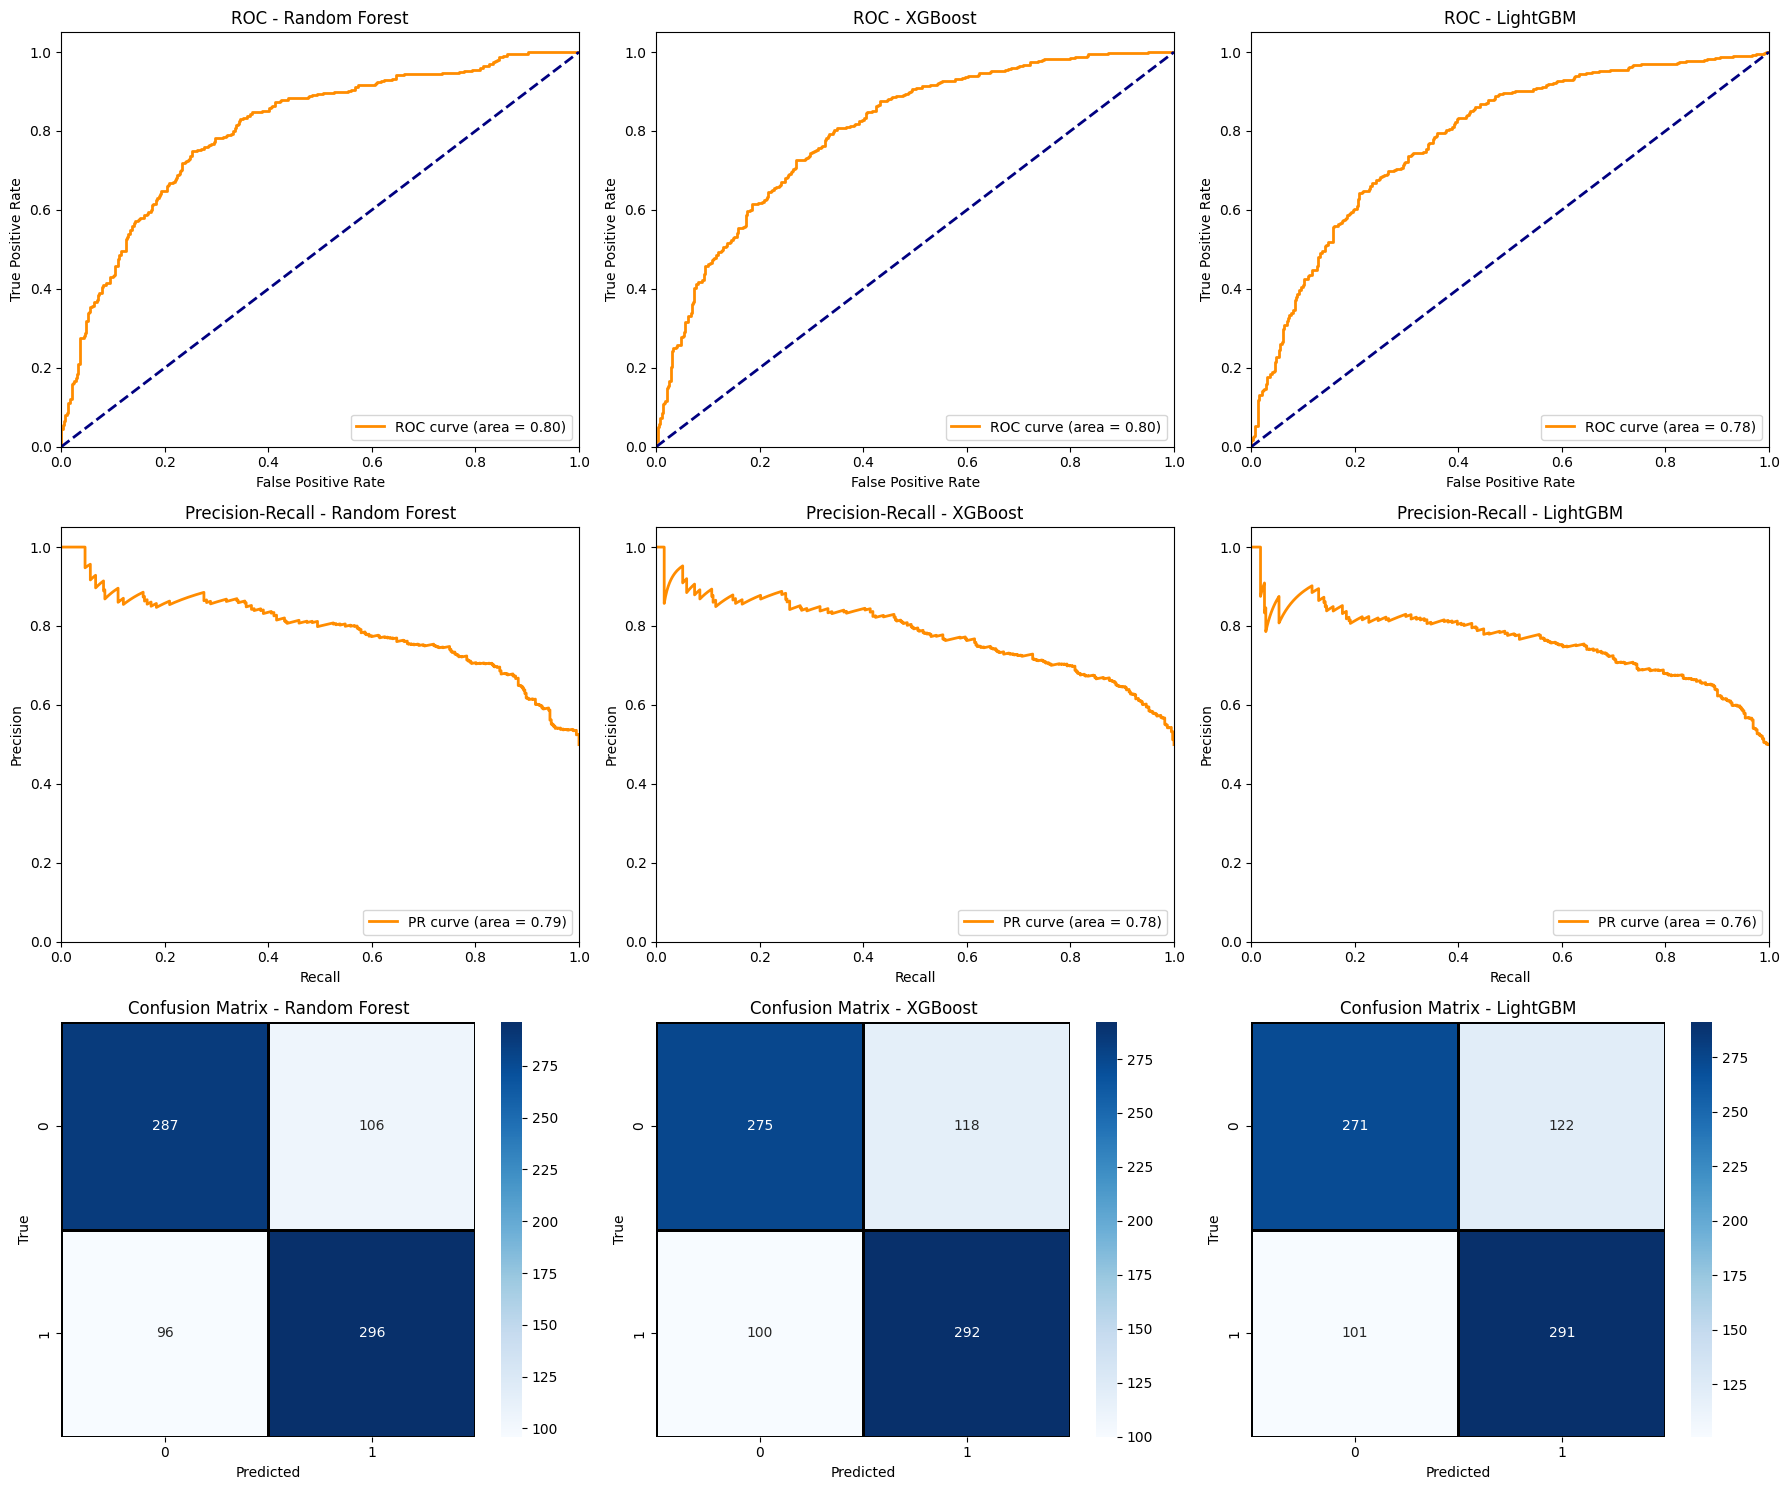

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def plot_all_metrics(models, X_test, y_test, model_names):
    fig, axes = plt.subplots(nrows=3, ncols=len(models), figsize=(18, 15))
    
    for i, model in enumerate(models):
        # ROC Curve
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        axes[0, i].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        axes[0, i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axes[0, i].set_xlim([0.0, 1.0])
        axes[0, i].set_ylim([0.0, 1.05])
        axes[0, i].set_xlabel('False Positive Rate')
        axes[0, i].set_ylabel('True Positive Rate')
        axes[0, i].set_title(f'ROC - {model_names[i]}')
        axes[0, i].legend(loc="lower right")
        
        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall, precision)
        axes[1, i].plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
        axes[1, i].set_xlim([0.0, 1.0])
        axes[1, i].set_ylim([0.0, 1.05])
        axes[1, i].set_xlabel('Recall')
        axes[1, i].set_ylabel('Precision')
        axes[1, i].set_title(f'Precision-Recall - {model_names[i]}')
        axes[1, i].legend(loc="lower right")
        
        # Confusion Matrix
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=2, linecolor='black', ax=axes[2, i])
        axes[2, i].set_xlabel('Predicted')
        axes[2, i].set_ylabel('True')
        axes[2, i].set_title(f'Confusion Matrix - {model_names[i]}')

    plt.tight_layout()
    plt.savefig(os.path.join(visual_dir, f'metrics_{trial_number_ml}.png'))
    plt.show()

models = [best_rf, best_xgb, best_lgb]
model_names = ['Random Forest', 'XGBoost', 'LightGBM']
plot_all_metrics(models, X_test, y_test, model_names)


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def plot_roc_curve(model, X_test, y_test, model_name='Model'):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_precision_recall_curve(model, X_test, y_test, model_name='Model'):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)

    plt.figure()
    plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(model, X_test, y_test, model_name='Model'):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=2, linecolor='black')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve

models = [best_rf, best_xgb, best_lgb]
model_names = ['Random Forest', 'XGBoost', 'LightGBM']
metrics_list = []

def evaluate_model_performance(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_pred_proba),
    }
    return metrics


# Plotting functions modified to save figures
def plot_and_save_figures(models, X_test, y_test, model_names, trial_number_ml):
    for model, model_name in zip(models, model_names):
        # ROC Curve
        plot_roc_curve(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'roc_curve_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()
        
        # Precision-Recall Curve
        plot_precision_recall_curve(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'precision_recall_curve_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()
        
        # Confusion Matrix
        plot_confusion_matrix(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'confusion_matrix_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()



In [12]:
# Evaluate and save metrics for each model
for model, name in zip(models, model_names):
    metrics = evaluate_model_performance(model, X_test, y_test, name)
    metrics_list.append(metrics)
    print(f"Metrics for {name}: {metrics}")

# Convert metrics to DataFrame sort bu 'Accuracy' and save
metrics_df = pd.DataFrame(metrics_list)
sorted_metrics_df = metrics_df.sort_values(by='Accuracy', ascending=False)
sorted_metrics_df.to_csv(os.path.join(results_dir, f'sorted_metrics_df_{trial_number_ml}.csv'), index=False)

Metrics for Random Forest: {'Model': 'Random Forest', 'Accuracy': 0.7426751592356687, 'Precision': 0.736318407960199, 'Recall': 0.7551020408163265, 'F1 Score': 0.7455919395465994, 'ROC AUC': 0.803013190008828}
Metrics for XGBoost: {'Model': 'XGBoost', 'Accuracy': 0.7222929936305732, 'Precision': 0.7121951219512195, 'Recall': 0.7448979591836735, 'F1 Score': 0.7281795511221945, 'ROC AUC': 0.7997870904086825}
Metrics for LightGBM: {'Model': 'LightGBM', 'Accuracy': 0.7159235668789808, 'Precision': 0.7046004842615012, 'Recall': 0.7423469387755102, 'F1 Score': 0.7229813664596274, 'ROC AUC': 0.7844679856675495}


In [13]:
metrics

{'Model': 'LightGBM',
 'Accuracy': 0.7159235668789808,
 'Precision': 0.7046004842615012,
 'Recall': 0.7423469387755102,
 'F1 Score': 0.7229813664596274,
 'ROC AUC': 0.7844679856675495}

In [14]:
# Assuming you have a list called metrics_list which contains the metrics dictionaries for each model
# And assuming each dictionary has a 'Model' key with the model's name and an 'Accuracy' key with its accuracy

# Extract accuracy scores and model names from metrics_list
accuracy_scores = [metrics['Accuracy'] for metrics in metrics_list]
model_names = [metrics['Model'] for metrics in metrics_list]

# Find the index of the highest accuracy
best_model_index = accuracy_scores.index(max(accuracy_scores))

# Retrieve the best model and its name using the index
best_model = models[best_model_index]
best_model_name = model_names[best_model_index]

# Print the best model name and its accuracy
print(f"Best Model: {best_model_name} with Accuracy: {accuracy_scores[best_model_index]:.4f}")


Best Model: Random Forest with Accuracy: 0.7427


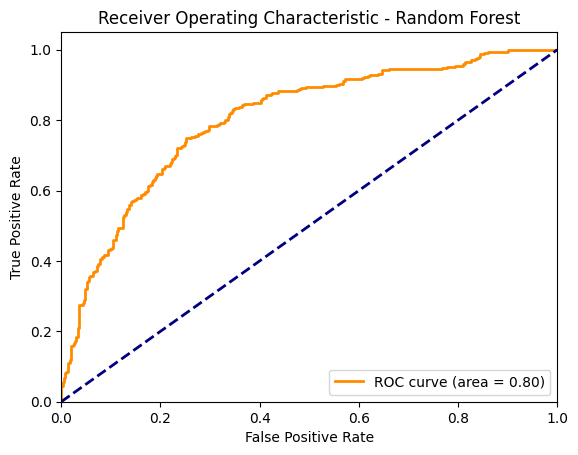

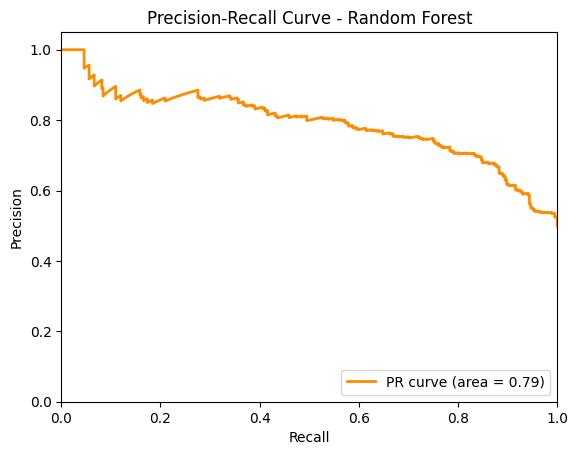

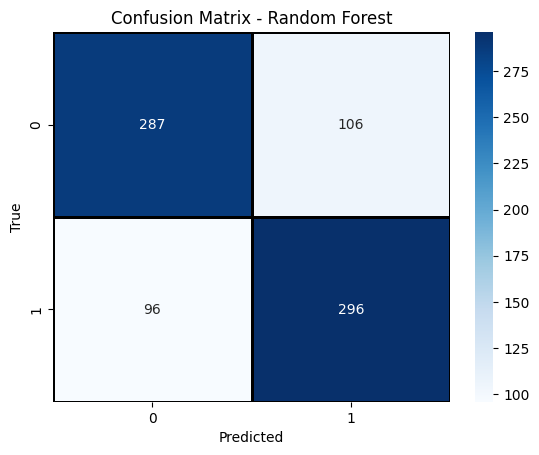

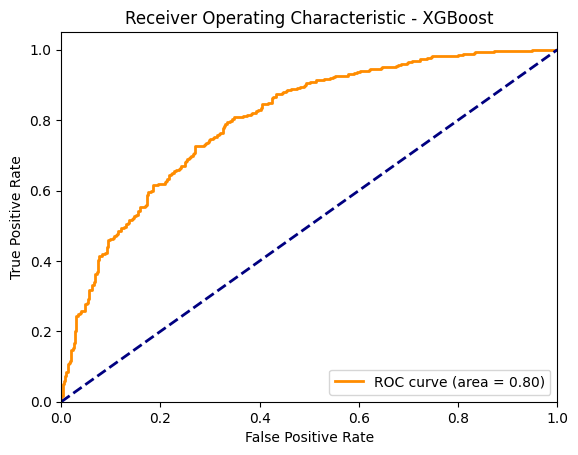

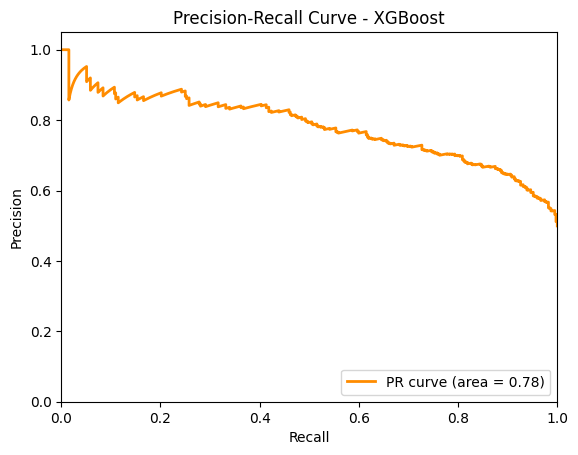

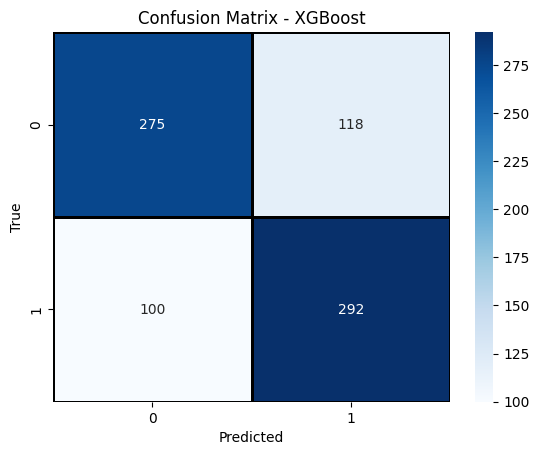

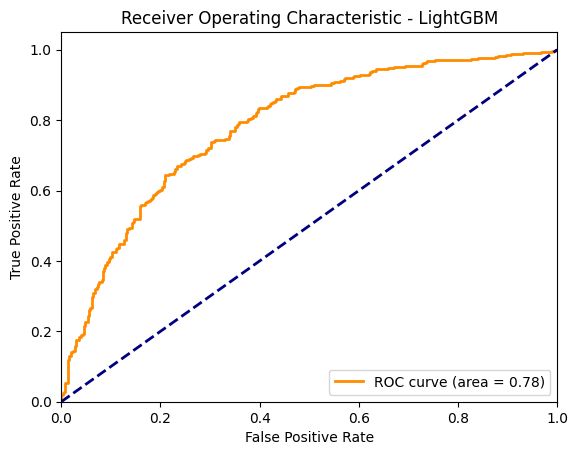

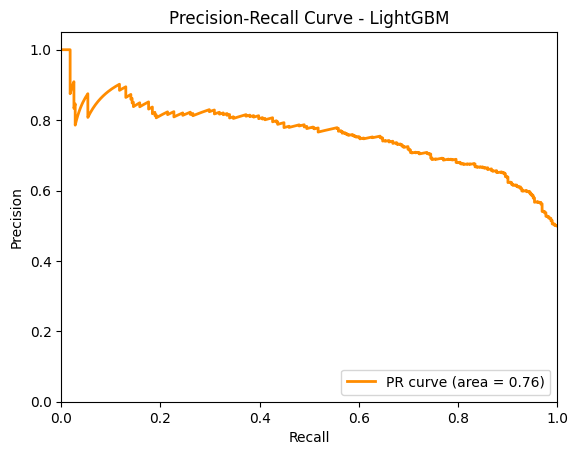

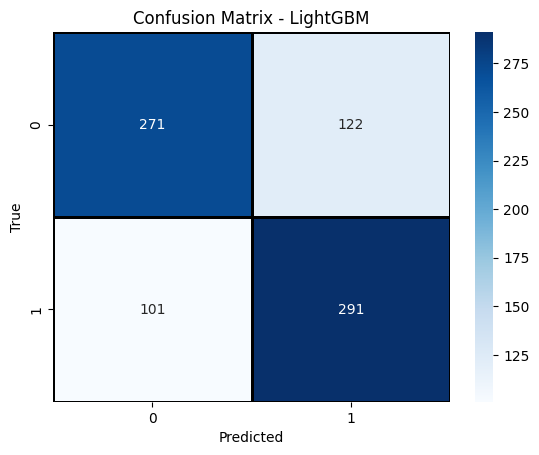

In [15]:
plot_and_save_figures(models, X_test, y_test, model_names, trial_number_ml)


In [16]:
def extract_feature_importances(model, feature_names):
    """
    Extract and sort the feature importances from the model.
    """
    feature_importances = model.feature_importances_
    sorted_idx = np.argsort(feature_importances)[::-1]
    return feature_names[sorted_idx], feature_importances[sorted_idx]

def plot_feature_importances(feature_names, feature_importances, title='Feature Importances', n_features=20):
    """
    Visualize the top N feature importances for interpretability.
    """
    plt.figure(figsize=(10, 8))
    sns.barplot(x=feature_importances[:n_features], y=feature_names[:n_features], orient='h')
    plt.title(title)
    plt.xlabel('Importance')
    plt.ylabel('Feature (Bit Index)')
    plt.savefig(os.path.join(features_dir, f'feature_importances_{trial_number_ml}.png'), dpi=300)
    plt.show()

def identify_important_features(feature_names, feature_importances, threshold=0.002):
    """
    Identify features with importance greater than a specified threshold.
    """
    return feature_names[feature_importances > threshold], feature_importances[feature_importances > threshold]

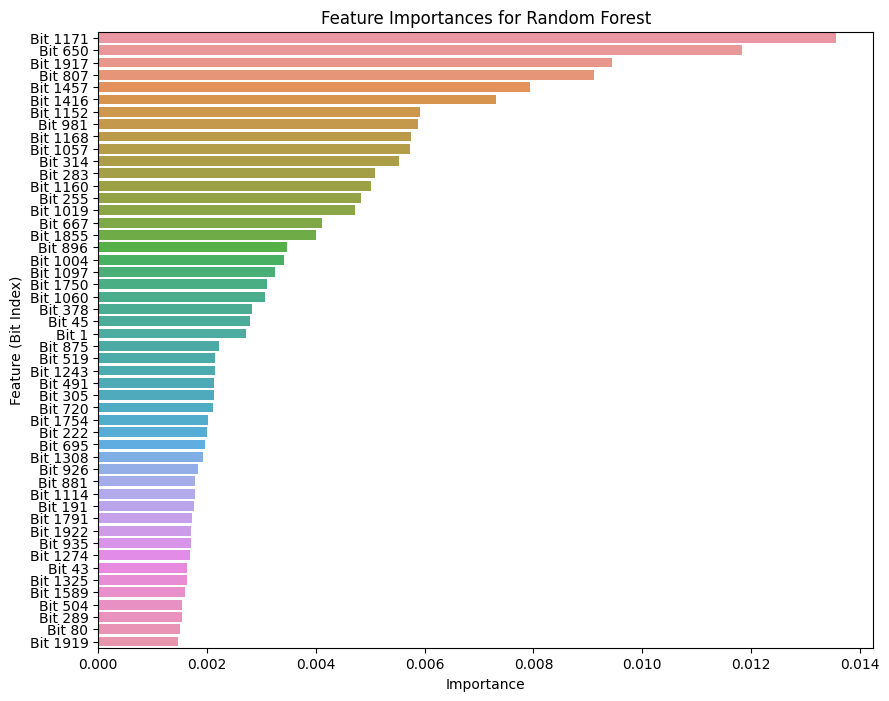

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib

feature_names = np.array(["Bit " + str(i) for i in range(X_train.shape[1])])  # Adjust based on your X_train


def save_feature_importances(model, feature_names, model_name, trial_number):
    sorted_names, sorted_importances = extract_feature_importances(model, feature_names)
    
    # Save to CSV
    features_df = pd.DataFrame({
        'Feature': sorted_names,
        'Importance': sorted_importances
    })
    csv_path = os.path.join(features_dir, f'feature_importances_{model_name}_{trial_number}.csv')
    features_df.to_csv(csv_path, index=False)
    
    # Plot and save visualization
    plot_feature_importances(sorted_names, sorted_importances, f'Feature Importances for {model_name}', n_features=50)
    plt.close()

save_feature_importances(best_model, feature_names, best_model_name, trial_number_ml)


In [18]:
import time

def save_feature_importances(model, feature_names, model_name, trial_number):
    sorted_names, sorted_importances = extract_feature_importances(model, feature_names)
    
    # Define file paths
    timestamp = time.strftime("%Y%m%d-%H%M%S")  # Current timestamp
    csv_filename = f'feature_importances_{model_name}_{trial_number}.csv'
    plot_filename = f'feature_importances_plot_{model_name}_{trial_number}.png'
    
    # Check if files exist and append timestamp to avoid overwriting
    csv_path = os.path.join(features_dir, csv_filename)
    if os.path.exists(csv_path):
        csv_path = os.path.join(features_dir, f'feature_importances_{model_name}_{trial_number}_{timestamp}.csv')
    
    plot_path = os.path.join(features_dir, plot_filename)
    if os.path.exists(plot_path):
        plot_path = os.path.join(features_dir, f'feature_importances_plot_{model_name}_{trial_number}_{timestamp}.png', dpi=300)

    # Save to CSV
    features_df = pd.DataFrame({'Feature': sorted_names, 'Importance': sorted_importances})
    features_df.to_csv(csv_path, index=False)
    
    # Plot and save visualization
    plot_feature_importances(sorted_names, sorted_importances, f'Feature Importances for {model_name}', n_features=20)
    plt.savefig(plot_path)
    plt.close()
